In [613]:
!pip install --upgrade gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 4.2 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [584]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.feature_extraction.text import TfidfVectorizer

In [450]:
X_train_pos = pd.read_csv("./all_positive_reviews_train.txt")


In [451]:
X_test_pos = pd.read_csv("./all_positive_reviews_test.txt")
X_train_neg = pd.read_csv("./all_negative_reviews_train.txt")
X_test_neg = pd.read_csv("./all_negative_reviews_test.txt")

In [452]:
X_train_pos.shape


(12499, 3)

In [453]:
X_train_pos_np = X_train_pos.to_numpy()


In [454]:
X_train_neg_np = X_train_neg.to_numpy()


In [455]:
X_train = np.concatenate((X_train_pos_np, X_train_neg_np), axis=0)

In [456]:

X_train.shape

(24998, 3)

In [457]:
np.random.shuffle(X_train)

In [458]:
X_train.shape

(24998, 3)

In [459]:
y_train = X_train[:,2]

In [460]:
y_train.shape

(24998,)

In [461]:
X_train = X_train[:, 1]
X_train.shape

(24998,)

Text Pre-Processing

In [463]:
import string
import nltk
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from nltk.stem.porter import PorterStemmer
import re

stopwords = nltk.corpus.stopwords.words('english')
stemmer = PorterStemmer()
tk = WhitespaceTokenizer()
def process_review(review):
    mod_review = []
    pat = re.compile(r"http\S+|\\S+|\d+|\<\S+|\/|\>|\!|\,|\.")
    review = re.sub(pat, "", review)
    review = re.sub(r' +', ' ', review)
    review = re.sub(r'\'', '', review)
    for word in word_tokenize(review):
        word = word.lower()
        if word not in string.punctuation and word not in stopwords and word.isalpha():
            stem_word = stemmer.stem(word)
            mod_review.append(stem_word)
    return ' '.join(mod_review)
            

In [464]:
X_train_mod = [ process_review(review) for review in X_train ]


In [467]:
X_train_mod[0]

'make book movi follow stori never good idea peopl read book automat start make mental movi charact look like place exist situat progress everybodi opu differ real movi final come your alway go segment audienc disappoint doesnt measur screenwrit director hope accomplish whatev vision movi hope come close possibl audienc expect see better case situat movi base novel stephen king filmmak captur least essenc stori result breathtak truli terrifi carri salem lot dead zone fan consid mess kubrick version shine miniseri tommyknock although even close perfect king adapt pet sematari mani moment uneas seem bled onto screen directli book pretti much forgiv shortcom music director mari lambert thank also direct siesta exactli horror movi anoth put list work screenplay probabl one better one sinc major know stori wont put sleep mani detail dr loui creed dale midkiff move famili perfect hous countri well almost perfect except two nasti littl detail danger busi stretch interst highway front larg pet

Feature Engineering:
Convert words or sentences into ML algorithm readable format. Different methods are
a. Word frequency / Count Vectorizer: Get the unique words list and create a map word to index and index to word. These indices are then vectorized and fed to Neural Network.
b. TFIDF : Instead of using word frequencies, use TFIDF scores to vectorize the input
   Both TFIDF and Word frequency method does not consider the word context. Both can be further improved by using ngram based model.
c. n-gram model : Use Bigram or trigram model with or without TFIDF for vectorizing the input
d. Word2Vec : Use pre-tuned word2vec model 
e. Glove : Use pre-tuned GloVe model from Stanford

In [616]:
# a. Word frequency based vectorization
def calculate_word_frequency(reviews):
    freq = {}
    for review in X_train_mod:
        for word in word_tokenize(review):
            word = word.lower()
            if word not in freq:
                freq[word] = 1
            else:
                freq[word] += 1
    return freq

def calculate_tfidf(reviews):
    tv = TfidfVectorizer(use_idf = True)
    tv_matrix = tv.fit_transform(X_train_mod)
    tv_matrix = tv_matrix.toarray()
    vocab = tv.get_feature_names_out()
    tfidf_dict = dict(zip(tv.get_feature_names_out(), tv_matrix.sum(axis=0)))
    tfidf_dict_sorted = sorted(tfidf_dict.items(), key = lambda x : x[1], reverse=True)
    return tfidf_dict_sorted


In [615]:
freq = calculate_word_frequency(X_train_mod)

In [472]:
freq_sorted = sorted(freq.items(), key = lambda x : x[1], reverse=True)

In [473]:
len(freq_sorted)

61603

In [702]:
# HyperParameters 
# max features = 40000
# Sequence length = 250 (words)
max_features = 40000
sequence_length = 250


In [703]:

uniq_words = [ t[0] for t in freq_sorted[:max_features] ]

In [704]:
len(uniq_words)

40000

In [705]:
w2i = { word:i for i, word in enumerate(uniq_words) }

In [706]:
i2w = { i:word for i, word in enumerate(uniq_words)}

Embedding the document or review into vector

In [707]:
def embed(review, sequence_length, w2i):
    r2v = []
    for word in word_tokenize(review):
        if len(r2v) >= sequence_length:
            break
        if word in w2i:
            r2v.append(w2i[word])
        else:
            r2v.append(0)
            
    # Add padding
    r2v += [0] * (sequence_length - len(r2v))
    return r2v

def embed_tfidf(review, sequence_length, tfidf_dict):
    r2v = []
    for word in word_tokenize(review):
        if len(r2v) >= sequence_length:
            break
        if word in tfidf_dict:
            r2v.append(tfidf_dict[word])
        else:
            r2v.append(0)

    # Add padding
    r2v += [0] * (sequence_length - len(r2v))
    return r2v



In [708]:
# input is integers of length 250. Vocab count is 10,000 
X = [ embed(review, sequence_length, w2i) for review in X_train_mod ]


In [709]:
split = int(0.8 * len(X))
split
X_tr  = X[:split]
y_tr = y_train[:split]
X_val = X[split+1:]
y_val = y_train[split+1:]

In [711]:
type(X_tr), type(y_tr)
y_tr = y_tr.astype(float)
y_val = y_val.astype(float)

In [712]:
x_tr_pt = torch.tensor(X_tr)
y_tr_pt = torch.from_numpy(y_tr).reshape(y_tr.shape[0], 1)


In [713]:
x_val_pt = torch.tensor(X_val)
y_val_pt = torch.from_numpy(y_val).reshape(y_val.shape[0], 1)

In [714]:
print(x_tr_pt.shape, x_val_pt.shape, y_tr_pt.shape, y_val_pt.shape)

torch.Size([19998, 250]) torch.Size([4999, 250]) torch.Size([19998, 1]) torch.Size([4999, 1])


In [715]:
class FNet(nn.Module):
    def __init__(self, num_features, emb_dim, hidden_layer_dim):
        super().__init__()
        
        self.num_features = num_features
        self.emb_dim = emb_dim
        self.emb = nn.Embedding(num_features, emb_dim)
        self.h1 = nn.Linear(emb_dim, hidden_layer_dim)
        self.out = nn.Linear(hidden_layer_dim, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        sequence_len = x.shape[1]
        x = self.emb(x)
        x = x.sum(1)/sequence_len
        x = self.h1(x)
        x = self.relu(x)
        x = self.out(x)
        return self.sigmoid(x)




In [716]:
lr = torch.linspace(-3, 0, 100)

In [717]:
batch_size = 32
lrs = torch.linspace(-3, 0, 100)
lrs = 10 ** lrs
fnet = FNet(max_features, 300, 150)
fnet.train()

def train(x, y, num_epochs, learning_rate):
    losses = []
    optimizer = torch.optim.Adam(fnet.parameters(), lr = learning_rate)
    loss_fn = nn.BCELoss()

    for i in range(num_epochs):
        idx = torch.randint(0, x.shape[0], (batch_size,))
        optimizer.zero_grad()
        yp = fnet(x[idx])
        loss = loss_fn(yp.type(torch.float64), y[idx])
        losses.append(loss.item())
        if i % 1000 == 0:
            print("Epoch {}, Loss {}".format(i, loss))
        loss.backward()
        optimizer.step()
    return fnet, losses, yp

def calculate_acc_pre_rec_f1_score(ypred, y):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for yp, yac in zip(ypred, y):
        if yp == 1.0 and yac == 1.0:
            tp += 1
        elif yp == 1.0 and yac == 0.0:
            fp += 1
        elif yp == 0.0 and yac == 0.0:
            tn += 1
        elif yp == 0.0 and yac == 1.0:
            fn += 1
    accuracy = tp / len(ypred)
    precision = tp / ( tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / ( precision + recall)
    print("Accuracy  : {}\n".format(accuracy))
    print("Precision : {}\n".format(precision))
    print("Recall    : {}\n".format(recall))
    print("F1-Score  : {}\n".format(f1_score))
    print("\t------ACTUAL-----\n")
    print("\tPositive\tNegative\n")
    print("Positive\t{}\t{}\n".format(tp, fp))
    print("Negative\t{}\t{}\n".format(fn, tn))
        

In [718]:
y_tr_pt.dtype

torch.float64

In [719]:
f, losses, ypred = train(x_tr_pt,y_tr_pt, 5000, 0.01)

Epoch 0, Loss 0.6984455149746407
Epoch 1000, Loss 0.1943558029906978
Epoch 2000, Loss 0.026375441969964195
Epoch 3000, Loss 0.00557380948199734
Epoch 4000, Loss 0.01704008828698148


In [721]:
y_tr.shape

(19998,)

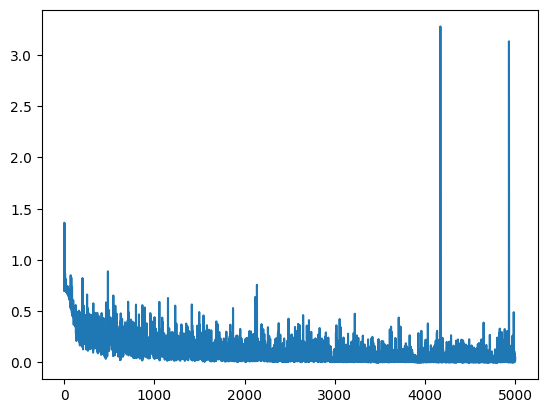

In [722]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)

In [389]:
list(f.parameters())[3]

Parameter containing:
tensor([[-0.2510,  0.2062,  0.3148, -0.2612, -0.2669,  0.2518,  0.1483, -0.2280,
         -0.2301,  0.2894,  0.2087, -0.2373, -0.3030, -0.2409, -0.1471,  0.2489,
          0.2776, -0.3038, -0.2527,  0.1947,  0.2777,  0.2190, -0.2608,  0.2135,
         -0.2205, -0.2332, -0.2860,  0.0346, -0.2785,  0.2339, -0.0416,  0.2446,
          0.2519, -0.2275, -0.2599, -0.2821, -0.2120, -0.0394, -0.0951,  0.2076,
         -0.2463,  0.2128,  0.2787, -0.2532, -0.2512,  0.2091,  0.1998,  0.0645,
          0.2639, -0.0049, -0.2413, -0.0943,  0.2013, -0.0023, -0.2264,  0.2538,
         -0.2394,  0.2622, -0.2368, -0.2149, -0.2684, -0.2075,  0.2409, -0.2705,
          0.2711,  0.1735, -0.2467,  0.2175, -0.0765,  0.2362, -0.2348,  0.2070,
         -0.0645, -0.2319,  0.2765,  0.2594, -0.2577,  0.0051,  0.2873,  0.2332,
          0.0743,  0.2413,  0.2214,  0.1911, -0.2036, -0.2758, -0.2621,  0.0320,
          0.2547, -0.3009, -0.0259, -0.0338,  0.0458, -0.2397,  0.2276,  0.1850,
      

In [723]:
fnet.eval()
yp_val = fnet(x_val_pt)
loss_fn = nn.BCELoss()
loss = loss_fn(yp_val.type(torch.float64), y_val_pt.type(torch.float64))
print(loss.item())

0.735631176028311


In [724]:
yp_val_np = yp_val.detach().numpy()
y_val_np = y_val_pt.detach().numpy()

In [725]:
yp_val_np_mod = []
for v in yp_val_np:
    if v >= 0.5:
        yp_val_np_mod.append(1.0)
    else:
        yp_val_np_mod.append(0.0)

yp_val_np_mod = np.array(yp_val_np_mod)

In [726]:
#yp_val_np_mod[:10],y_val_np[:10]
for i in range(0, 10):
    print(X_train[split + 1 + i ], y_val_np[i], yp_val_np_mod[i])

Andy Goldsworthy is a taoist master of the first order, expressing the Way through his sublime ephemeral art. Indeed, time and change is what his work is fundamentally about. I bought his first book several years ago and my family has marveled at it many times. So it was a treat to get to know the artist personally through this film, he is just as patient and gentle as you would expect, and has some wonderful things to say about the natural world, the deepest of which are expressed in his occasional inability to say it in words at all. He is like most children who play in the great outdoors alone (if they do anymore), creating things from sticks and sand and mud and snow before they outgrow it. Mr. Goldsworthy was given the gift and the mission to extend that sort of play to create profound visions of nature, and to open our often weary eyes to it in brilliant new ways. And always with the utmost respect, gratitude and humor of a wandering, and wondering monk. [1.] 1.0
Cinderella is a 

In [728]:
from sklearn.metrics import confusion_matrix

y_val_np = y_val_pt.detach().numpy()
yp_val_np = yp_val.detach().numpy()

In [729]:
yp_val.shape, yp_val_np.shape

(torch.Size([4999, 1]), (4999, 1))

In [730]:
print(y_val_np.shape, yp_val_np.shape)

(4999, 1) (4999, 1)


In [731]:
yp_val_np_mod = []
for v in yp_val_np:
    y = 0.0
    if v > 0.9 :
        y = 1.0
    yp_val_np_mod.append(y)
        

In [732]:
len(yp_val_np_mod)

4999

In [733]:
yp_val_np = np.array(yp_val_np_mod).reshape(len(yp_val_np_mod), 1)

In [734]:
yp_val_np.shape

(4999, 1)

In [735]:
confusion_matrix(yp_val_np, y_val_np)

array([[2249,  458],
       [ 238, 2054]])

In [736]:
calculate_acc_pre_rec_f1_score(yp_val_np, y_val_np)

Accuracy  : 0.41088217643528707

Precision : 0.8961605584642234

Recall    : 0.8176751592356688

F1-Score  : 0.8551207327227311

	------ACTUAL-----

	Positive	Negative

Positive	2054	238

Negative	458	2249



In [ ]:
yp